# Group 3

### Classify orthopaedic patients

**Given data containing values for six biomechanical features classify orthopaedic patients into 3 classes normal, disk hernia or spondilolysthesis**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import ppscore as pps
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import zscore
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, accuracy_score, roc_curve, ConfusionMatrixDisplay, confusion_matrix

### Loading Data

In [ ]:
with open('column_3C_weka.arff') as f:
    data = f.readlines()

attribute = []
for dt in data:
    if 'attribute' in dt:
        attribute.append(dt.split(' ')[1])

print("Attributes for the data are: ", attribute)

FileNotFoundError: ignored

In [ ]:
data_main = []
flag=0
for dt in data:
    if flag:
        d = dt[:].split(',')
        d[-1] = d[-1][:-1]
        d[:-1] = [float(l) for l in d[:-1]]
        data_main.append(d)
    if 'data' in dt:
        flag=1

NameError: ignored

In [ ]:
df = pd.DataFrame(data_main, columns=attribute)
# df["class"] = [1 if each == "Abnormal" else 0 for each in df["class"]]
df.head()

In [ ]:
df.describe()

In [ ]:
df[df['class']=='Normal'].info()

No null values are present and all the data types are correct

In [ ]:
df.isnull().sum()

In [ ]:
df.nunique(axis=0)

In [ ]:
## Checking for outliers
num_attributes = attribute[:-1]

Q1 = df[num_attributes].quantile(0.25)
Q3 = df[num_attributes].quantile(0.75)
IQR = Q3-Q1
x = (df[num_attributes]<Q1-1.5*IQR) | (df[num_attributes]>Q3+1.5*IQR)
x = pd.DataFrame(x)
for at in num_attributes:
    print("No. of outliers in attribute", at, "=", x[at].sum())

In [ ]:
# attribute

##  Data Visualisatons

3 [150, 100, 60]


Text(0.5, 1.0, 'Distribution of Patients')

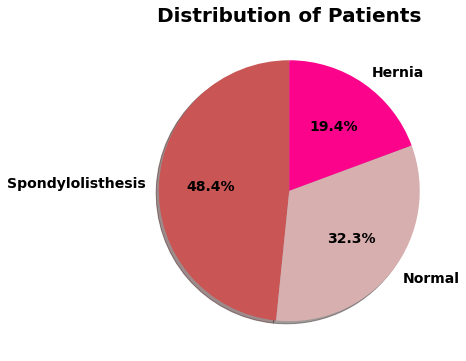

In [ ]:
#  Various types of patients and their distribution

labels = df["class"].value_counts().index.tolist()
# labels = ["Abnormal", "Normal"]
sizes = df["class"].value_counts().tolist()
print(len(labels), sizes)
# print("Count of Abnormal samples:", sizes[0])
# print("Count of Normal samples:", sizes[1])
colors = ["#C95555", "#D8AFAF", "#FC038C"]
# explode = (0, 0)
fig, ax = plt.subplots(1,1, figsize=(14,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 14, "fontweight" : "bold"}, colors=colors)
plt.title("Distribution of Patients", size=20, fontweight="bold")

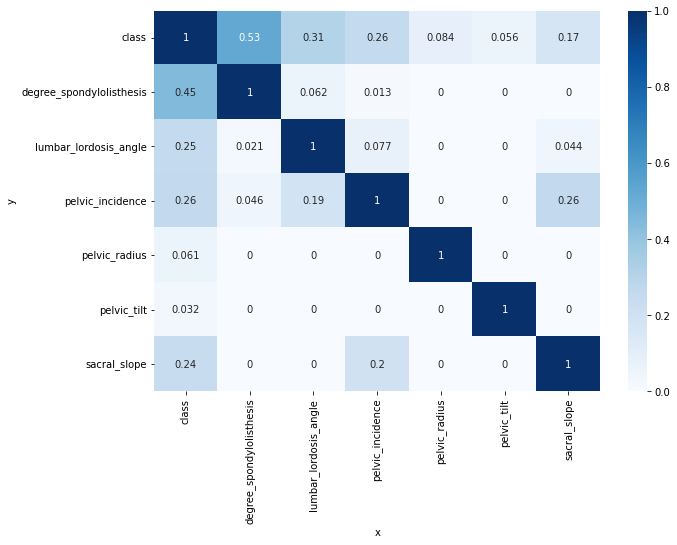

In [ ]:
# Heatmap with PP score
matrix = pps.matrix(df).pivot(columns='x',index='y',values='ppscore')
# df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(matrix,annot=True,cmap="Blues")
# Attribute (float type) relation with class (object type) can be seen through PP score.

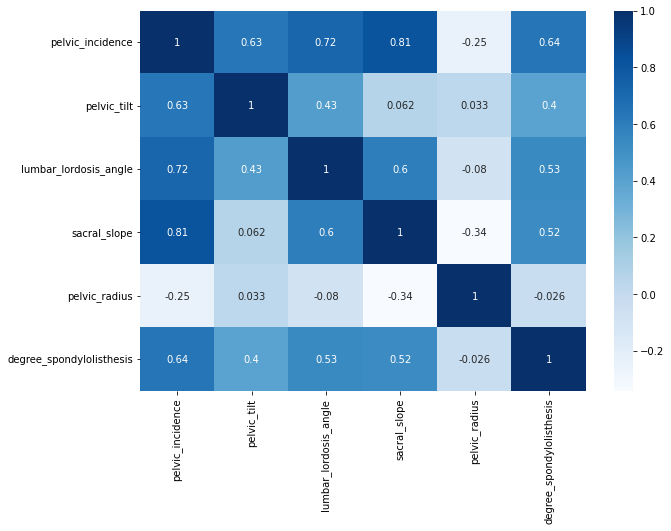

In [ ]:
# heatmap with Correlation matrix score
matrix = df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(matrix,annot=True,cmap="Blues")

#### Since we are having high correlation values, thus we have redundant attributes which can be reduced using PCA

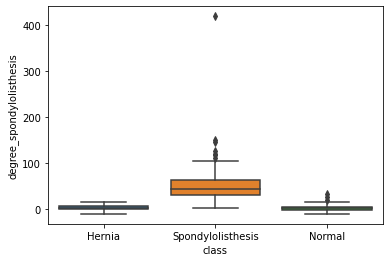

In [ ]:
sns.boxplot(x="class",y='degree_spondylolisthesis',data=df)

That one point that outstands the whole data set is a noise.

#### Removing the outlier i.e. data data points with degree_spondylolisthesis > 400

In [ ]:
#Removing Outlier
idx = list(df[df["degree_spondylolisthesis"]>400].index)
df.drop(idx,inplace=True,axis=0)

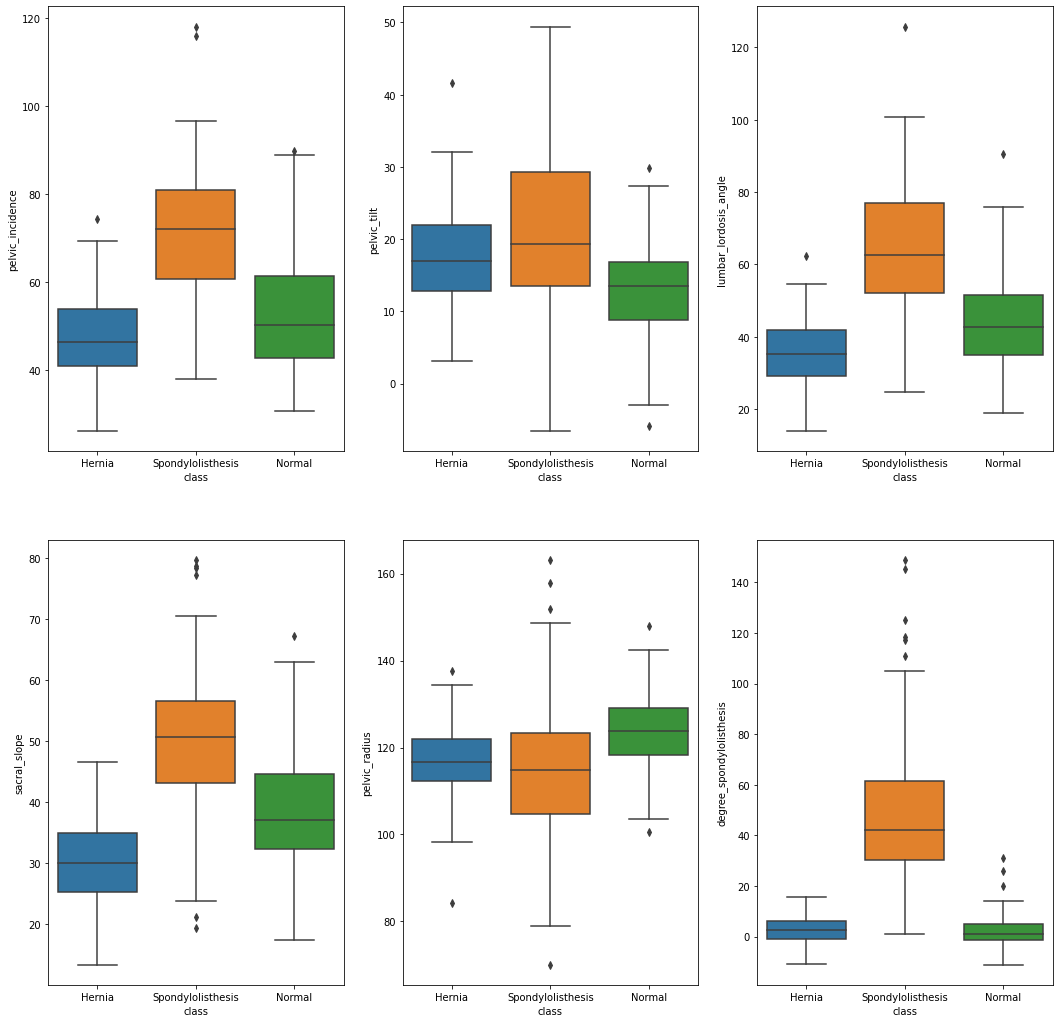

In [ ]:
num_attributes = attribute[:-1]
rows=2
cols=3
plt.figure(figsize=(18,18))
for cn,cn_name in enumerate(num_attributes):
    plt.subplot(rows,cols,cn+1)
    sns.boxplot(x="class",y=cn_name,data=df)

We can see that pelvic tilt for normal class is quite lower than other two classes and pelvic radius of the same is relatively high. Also Sacral_slope, lumber_lordosis_angle and degree_spondylolisthesis are more for spondylolisthesis than normal class and hernia.

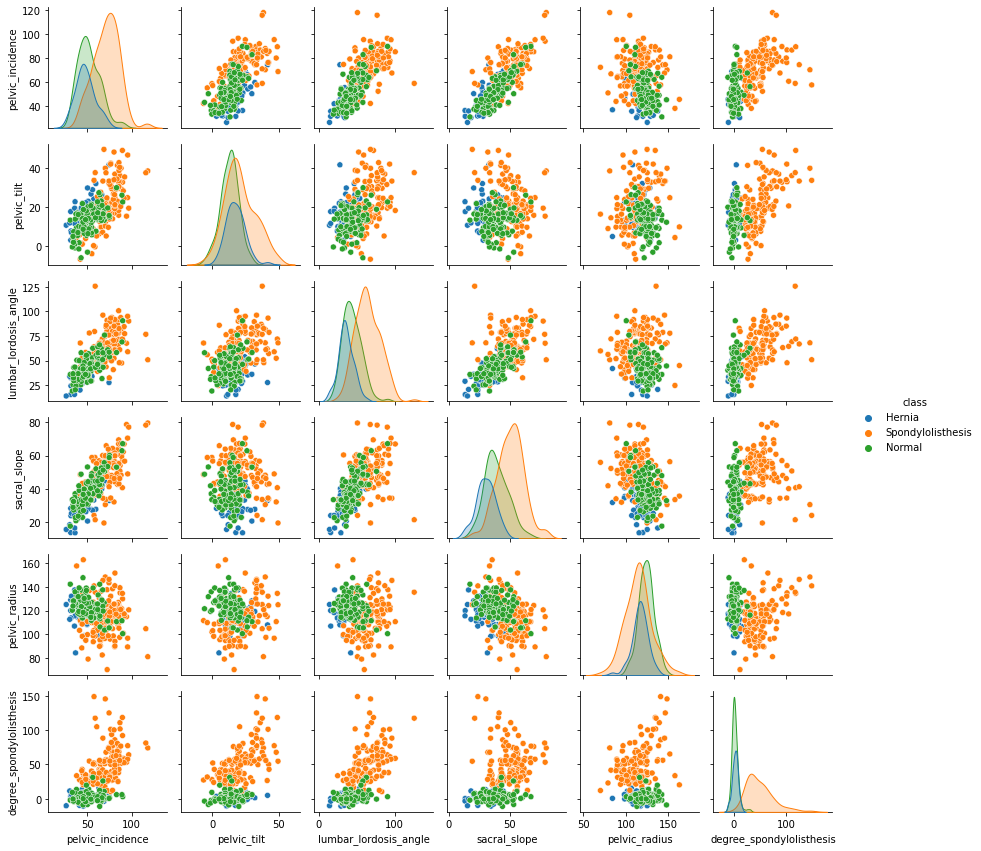

In [ ]:
sns.pairplot(df, hue='class', height=2)

### We can see that the average degree spondylolisthesis value in abnormal patients is pretty higher than average the degree spondylolisthesis value in normal patients. Sacral_slope is relatively low in case of Hernia.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c01d38390>,
      dtype=object)

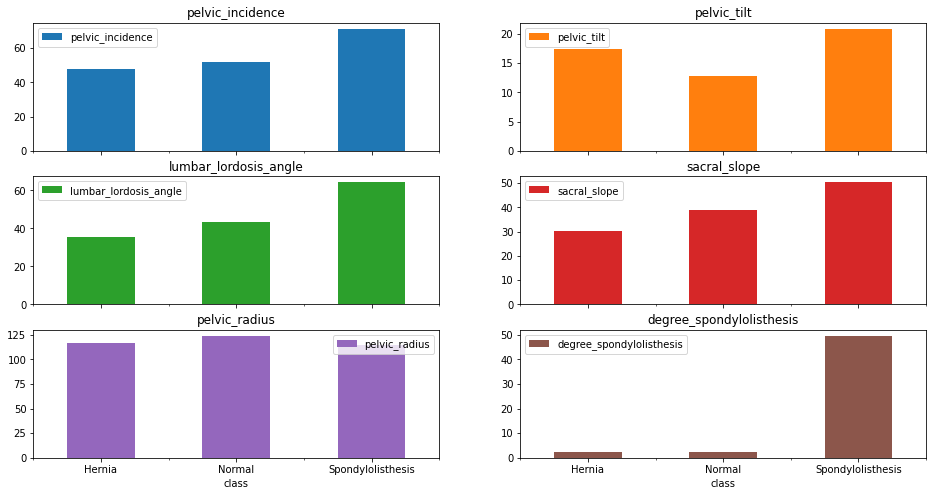

In [ ]:
df_grouped = df.groupby("class").agg("mean")
# df_grouped
df_grouped.plot.bar(rot=0, figsize=(16,8), subplots=True, layout=(3,2))

The mean values for pelvic radius for all the three classes are almost similar and that for degree_spondylolisthesis is very high for the pateints suffering from spondylolisthesis as compared to other two classes so it can be used as a major attribute to classify a pateint in spondylolisthesis.

### Normalising Data

In [ ]:
X = df.iloc[:,:6]
y = df['class'].map({'Hernia': 1, 'Normal': 0, 'Spondylolisthesis': 2})
xz = X.apply(zscore)
xztrain, xztest, ytrain, ytest = train_test_split(xz, y, test_size=0.3, random_state=20)
counter = Counter(y)
print(counter)

Counter({2: 149, 0: 100, 1: 60})


Standardizing the data as many attributes may have different units and scale.

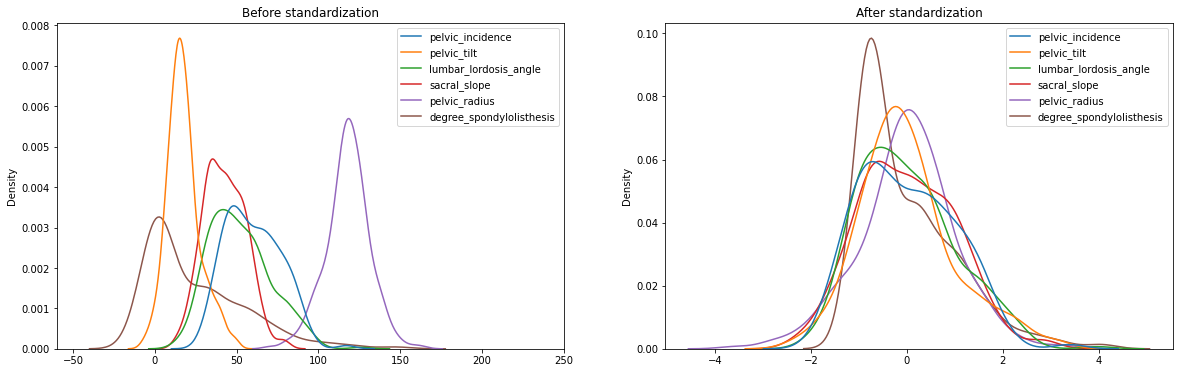

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))
ax1.set_title('Before standardization')
sns.kdeplot(data=X, ax=ax1)
ax1.set_xlim(-60,250)
ax2.set_title('After standardization')
sns.kdeplot(data=xz, ax=ax2)
plt.show()

In [ ]:
smote = SMOTE(random_state = 20)
xzstrain, ystrain = smote.fit_resample(xztrain, ytrain)
counter = Counter(ystrain)
print(counter)

Counter({0: 104, 1: 104, 2: 104})


We see that for the density of the train dataset, degree of spodylolisthesis has the highest value.

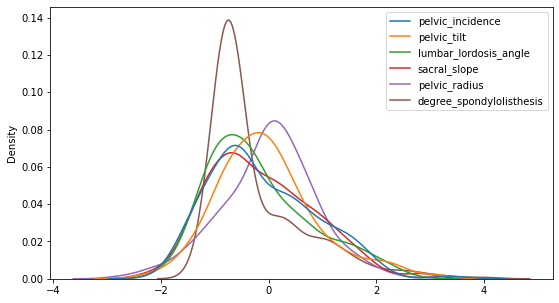

In [ ]:
plt.figure(figsize=(9,5))
sns.kdeplot(data=xzstrain)
plt.show()

Recombining the split data with its class.

In [ ]:
data_scaled = xzstrain.copy()
data_scaled['class'] = ystrain
data_scaled['class'] = data_scaled['class'].map({1:'Hernia', 0:'Normal', 2:'Spondylolisthesis'})
data_scaled

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,-1.343472,-0.819038,-0.535893,-1.134142,1.336917,-0.375821,Normal
1,-1.285901,-0.412980,-1.128790,-1.378486,0.391254,-0.781776,Hernia
2,0.603605,-0.410455,0.498982,1.124288,-1.173746,0.016933,Spondylolisthesis
3,-0.283714,0.252408,-0.428094,-0.575424,0.352884,0.315573,Spondylolisthesis
4,0.594731,-0.723605,1.316645,1.359820,0.096451,0.253078,Spondylolisthesis
...,...,...,...,...,...,...,...
307,-1.232159,-0.193055,-1.050381,-1.480920,0.314243,-0.829432,Hernia
308,-1.105010,-0.489420,-1.217194,-1.078330,-0.092727,-0.862067,Hernia
309,0.190665,0.216794,0.175257,0.081548,-0.646592,-0.929366,Hernia
310,-0.653008,-0.243125,-0.863186,-0.673645,0.399230,-0.580537,Hernia


Here we are plotting the box plot for the normalized data with respect to the class i.e. normal, hernia and spondylolisthesis.

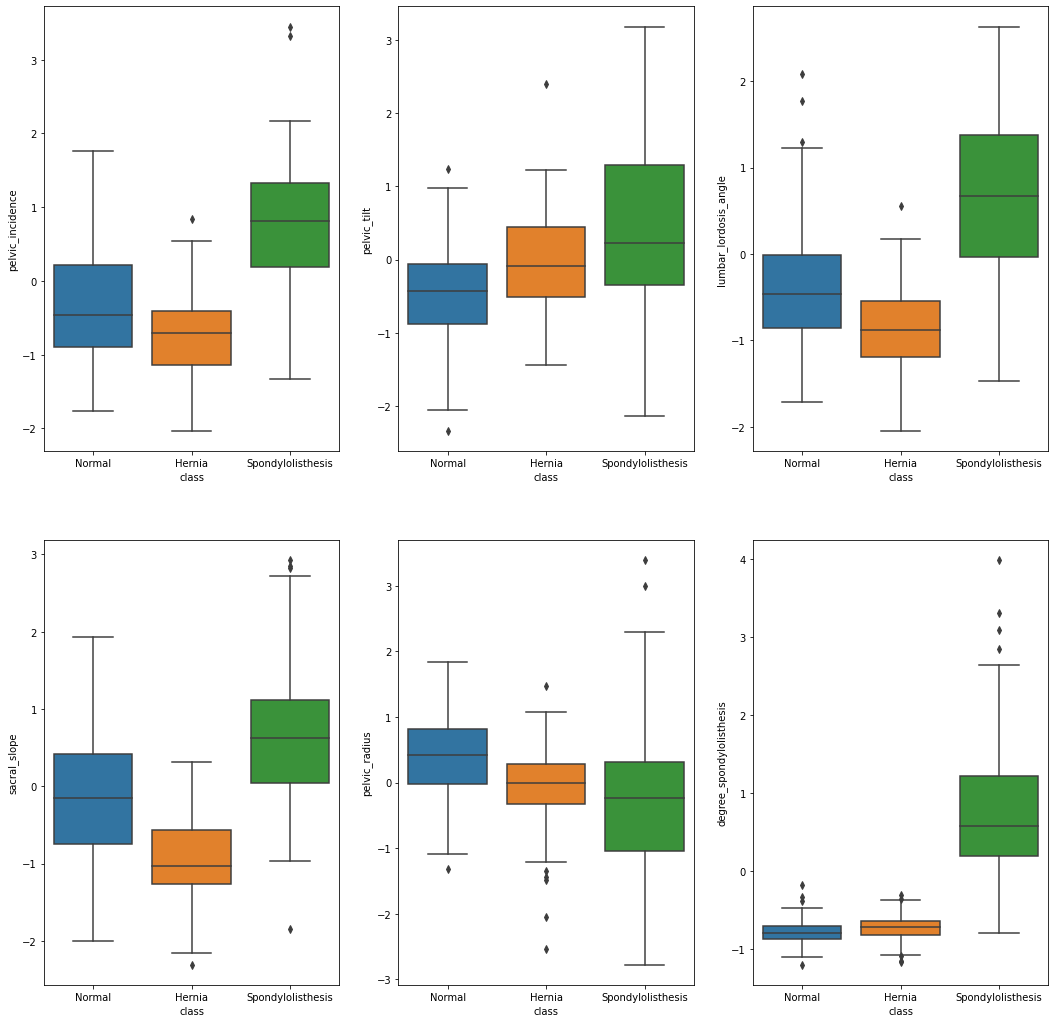

In [ ]:
num_attributes = attribute[:-1]
rows=2
cols=3
plt.figure(figsize=(18,18))
for cn,cn_name in enumerate(num_attributes):
    plt.subplot(rows,cols,cn+1)
    sns.boxplot(x="class",y=cn_name,data=data_scaled)

In [ ]:
# {1:'Hernia', 0:'Normal', 2:'Spondylolisthesis'}
counter = Counter(ytest)
print(counter)

Counter({2: 45, 0: 31, 1: 17})


So, the no. of samples to corresponding class in the test set are:-
* **Normal**: 31
* **Hernia**: 17
* **Spondylolisthesis**: 45

## Classifiers

We have trained and tested 6 models on our dataset:

* Decision Tree Classifier
* K-Nearest Neighors Classifier
* Support Vector Machine
* Naive Bayes
* Random Forest
* Neural Network



#### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(xzstrain, ystrain)
path = decision_tree.cost_complexity_pruning_path(xzstrain, ystrain)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

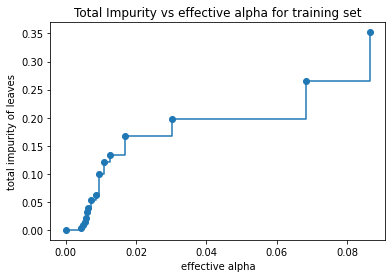

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(xzstrain, ystrain)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3144654088050315


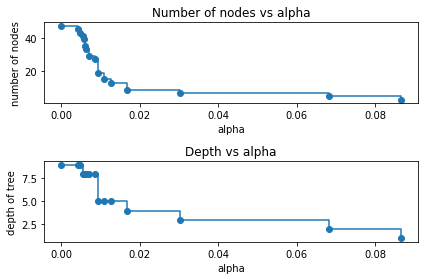

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()


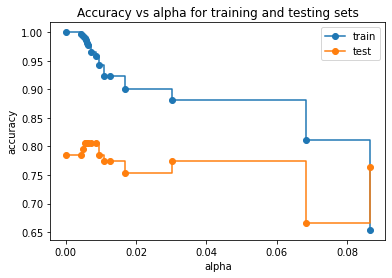

In [ ]:
train_scores = [clf.score(xzstrain, ystrain) for clf in clfs]
test_scores = [clf.score(xztest, ytest) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
decision_tree_test_acc = max(test_scores)
decision_tree_train_acc = train_scores[test_scores.index(decision_tree_test_acc)]
print('Train accuracy: ', decision_tree_train_acc, '\nTest accuracy: ', decision_tree_test_acc)

Train accuracy:  0.9903846153846154 
Test accuracy:  0.8064516129032258


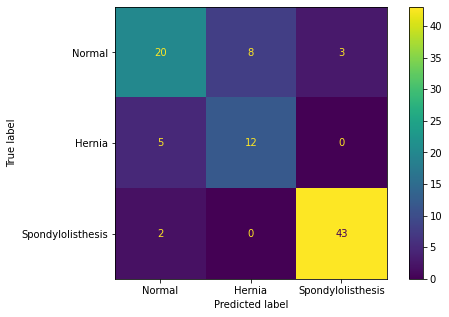

In [ ]:
y_pred = decision_tree.predict(xztest)
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(ytest, y_pred),
    display_labels= ['Normal','Hernia','Spondylolisthesis'],
)
cmp.plot(ax=ax)
plt.show()

#### Random Forest







In [ ]:
from sklearn.ensemble import RandomForestClassifier
random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [50, 100, 300], 'max_depth':[5, 10, 15]}, cv=5).fit(xzstrain, ystrain)
random_forest.fit(xzstrain, ystrain)
random_forest_acc = random_forest.score(xzstrain, ystrain) * 100
random_forest_acc

100.0

In [ ]:
random_forest_test_acc = random_forest.score(xztest, ytest) * 100
random_forest_test_acc

81.72043010752688

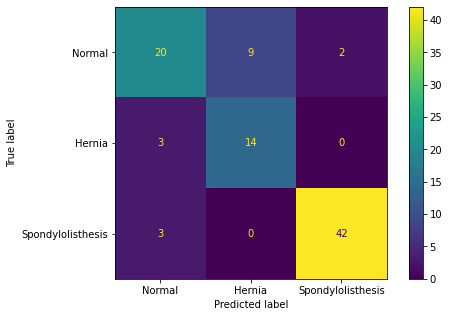

In [ ]:
y_pred = random_forest.predict(xztest)
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(ytest, y_pred),
    display_labels= ['Normal','Hernia','Spondylolisthesis'],
)
cmp.plot(ax=ax)
plt.show()

#### K Nearest Neighbours

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [2, 3]}, cv=10).fit(xzstrain, ystrain)
knn_acc = knn.score(xzstrain, ystrain) * 100
knn_acc

96.47435897435898

In [ ]:
knn_test_acc = knn.score(xztest, ytest) * 100
knn_test_acc

72.04301075268818

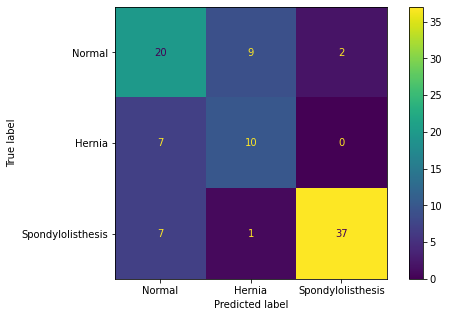

In [ ]:
y_pred = knn.predict(xztest)
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(ytest, y_pred),
    display_labels= ['Normal','Hernia','Spondylolisthesis'],
)
cmp.plot(ax=ax)
plt.show()

#### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(xzstrain, ystrain)
svc_acc = svc.score(xzstrain, ystrain) * 100
svc_acc

91.02564102564102

In [ ]:
svc_test_acc = svc.score(xztest, ytest) * 100
svc_test_acc

79.56989247311827

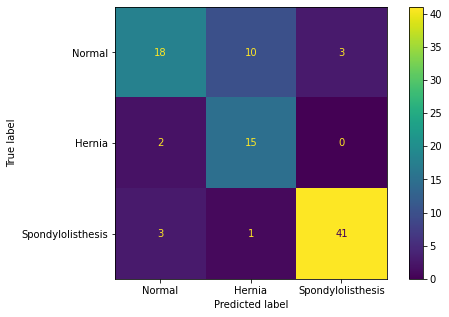

In [ ]:
y_pred = svc.predict(xztest)
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(ytest, y_pred),
    display_labels= ['Normal','Hernia','Spondylolisthesis'],
)
cmp.plot(ax=ax)
plt.show()

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(xzstrain, ystrain)
gaussian_acc = gaussian.score(xzstrain, ystrain) * 100
gaussian_acc

82.6923076923077

In [ ]:
gaussian_test_acc = gaussian.score(xztest, ytest) * 100
gaussian_test_acc

79.56989247311827

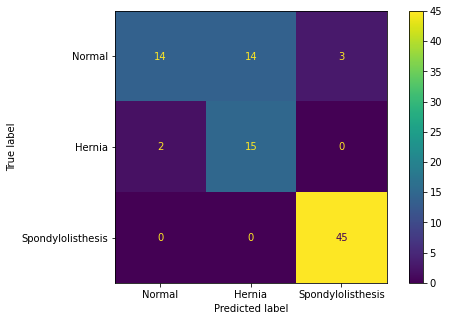

In [ ]:
y_pred = gaussian.predict(xztest)
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(ytest, y_pred),
    display_labels= ['Normal','Hernia','Spondylolisthesis'],
)
cmp.plot(ax=ax)
plt.show()

#### Neural Network

In [ ]:
# NN models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model creation
model = Sequential()
model.add(Dense(16, input_dim = xzstrain.shape[1], activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(3, activation = 'sigmoid'))
model.summary()


def decay_schedule(epoch, lr, step=50):
    # decay by 0.1 every 5 epochs; use `% 1` to decay after each epoch
    if (epoch % step == 0) and (epoch != 0):
        lr = lr * 0.5
    return lr

lr_scheduler = LearningRateScheduler(decay_schedule)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 16)                112       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_29 (Dense)            (None, 16)                272       
                                                                 
 dense_30 (Dense)            (None, 3)                 51        
                                                                 
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# es = EarlyStopping(monitor='val_accuracy', patience=40, mode='max')
hist = model.fit(xztrain, ytrain, batch_size=64, validation_data=(xztest, ytest),
               epochs=500, verbose=1)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
# Create MultiLabelBinarizer object
mlb = MultiLabelBinarizer()
yt = np.transpose(np.array([ytrain]))
yte = np.transpose(np.array([ytest]))
Y = mlb.fit_transform(yt)
Yt = mlb.fit_transform(yte)

es = EarlyStopping(monitor='val_accuracy', patience=40, mode='max')
hist = model.fit(xztrain, Y, batch_size=64, validation_data=(xztest, Yt),
               epochs=500, verbose=1, callbacks=[es])

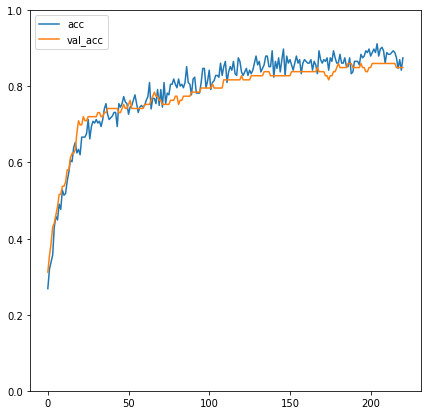

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
plt.ylim((0, 1))
plt.legend()

Finally after training for 221 epochs,
* Training Accuracy: 87.50%
* Testing Accuracy: 84.95%

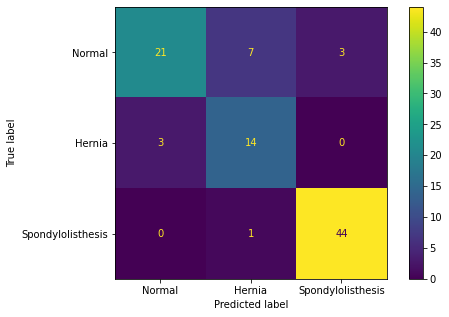

In [ ]:
y_pred = model.predict(xztest)
y_pred = y_pred.argmax(axis=1)
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(ytest, y_pred),
    display_labels= ['Normal','Hernia','Spondylolisthesis'],
)
cmp.plot(ax=ax)
plt.show()

#### Accuracy Comparision of Different Classification Models

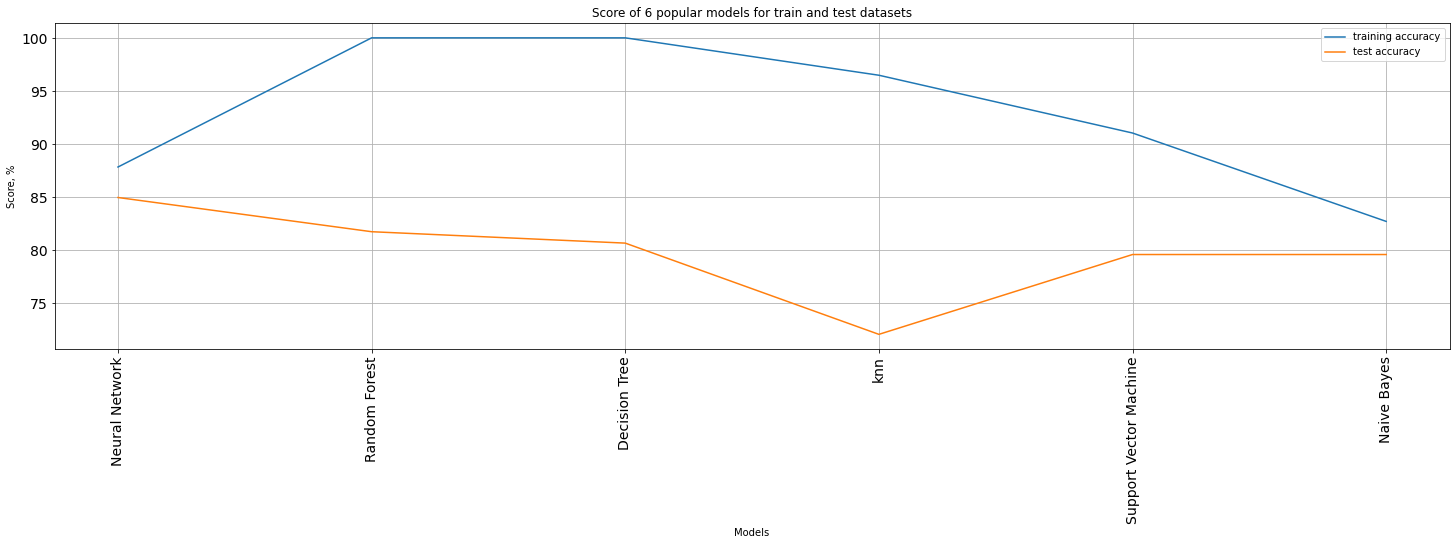

In [ ]:
classifiers = {"Neural Network": model, "Random Forest": random_forest, "Decision Tree":decision_tree, "knn":knn, "Support Vector Machine":svc, "Naive Bayes":gaussian}
accuracy = {}
accuracy['model'] = []
accuracy['train_acc'] = []
accuracy['test_acc'] = []

for key, classifier in classifiers.items():
    if key!="Neural Network":
        y_test_pred = classifier.predict(xztest)
        y_train_pred = classifier.predict(xzstrain)
    else:
        y_test_pred = classifier.predict(xztest)
        y_test_pred = y_test_pred.argmax(axis=1)
        y_train_pred = classifier.predict(xzstrain)
        y_train_pred = y_train_pred.argmax(axis=1)
    accuracy['model'].append(key)
    accuracy['train_acc'].append(accuracy_score(ystrain, y_train_pred)*100)
    accuracy['test_acc'].append(accuracy_score(ytest, y_test_pred)*100)

plt.figure(figsize=[25,6])
xx = accuracy['model']
plt.tick_params(labelsize=14)
plt.plot(xx, accuracy['train_acc'], label = 'training accuracy')
plt.plot(xx, accuracy['test_acc'], label = 'test accuracy')
plt.legend()
plt.title('Score of 6 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Score, %')
plt.xticks(xx, rotation='vertical')
plt.grid()
plt.show()

#### ROC Curve for Normal vs Abnormal Classification

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance.

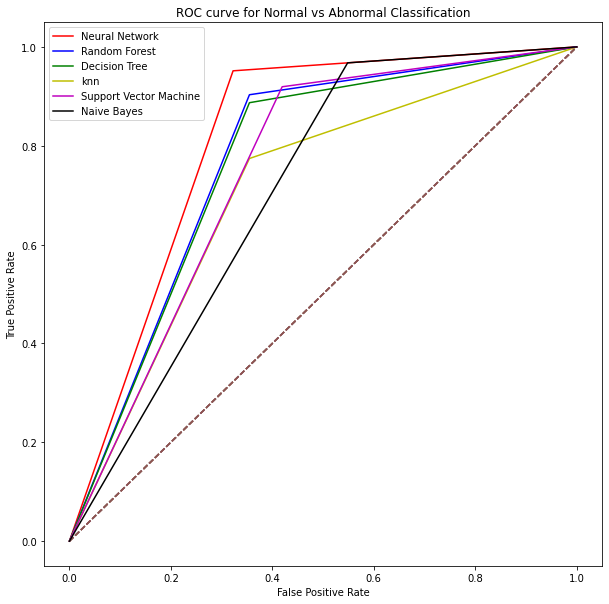

In [ ]:
color = {"Neural Network": 'r-', "Random Forest": 'b-', "Decision Tree":'g-', "knn":'y-', "Support Vector Machine":'m-', "Naive Bayes":'k-'}
plt.figure(figsize=(10, 10))
for key, classifier in classifiers.items():
    if key!="Neural Network":
        y_pred = classifier.predict(xztest)
    else:
        y_pred = classifier.predict(xztest)
        y_pred = y_pred.argmax(axis=1)
    prediction = [1 if y==2 else y for y in y_pred]
    test_y = [1 if y==2 else y for y in ytest]
    fpr, tpr, thresholds = roc_curve(test_y, prediction)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, color[key],label=key)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for Normal vs Abnormal Classification')

plt.legend(loc="upper left")
plt.show()

Among all algorithms, **Neural Network** performed the best giving an accuracy of 84.5% on the test set.

Overall we observe that models are facing issues while predicting data from **Hernia** class as many are getting classified as **Normal**.


